Choose file to use as input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_index = 7
simulation_days_count = 1000
plot_days_count = 1000
false_signals_offset = 0

data_files = [
    # korean won to us dollar
    ('data/krwusd_1994-2024.csv', 'KRW/USD'), # 0
    ('data/krwusd_2004-2024.csv', 'KRW/USD'), # 1
    ('data/krwusd_2014-2024.csv', 'KRW/USD'), # 2
    ('data/krwusd_2019-2024.csv', 'KRW/USD'), # 3
    # korean won to polish zloty
    ('data/krwpln_1994-2024.csv', 'KRW/PLN'), # 4
    ('data/krwpln_2004-2024.csv', 'KRW/PLN'), # 5
    ('data/krwpln_2014-2024.csv', 'KRW/PLN'), # 6
    ('data/krwpln_2019-2024.csv', 'KRW/PLN'), # 7
    # us dollar to polish zloty
    ('data/usdpln_1994-2024.csv', 'USD/PLN'), # 8
    ('data/usdpln_2004-2024.csv', 'USD/PLN'), # 9
    ('data/usdpln_2014-2024.csv', 'USD/PLN'), # 10
    ('data/usdpln_2019-2024.csv', 'USD/PLN'), # 11
    # euro to polish zloty
    ('data/eurpln_1994-2024.csv', 'EUR/PLN'), # 12
    ('data/eurpln_2004-2024.csv', 'EUR/PLN'), # 13
    ('data/eurpln_2014-2024.csv', 'EUR/PLN'), # 14
    ('data/eurpln_2019-2024.csv', 'EUR/PLN'), # 15
    # euro to us dollar
    ('data/eurusd_1994-2024.csv', 'EUR/USD'), # 16
    ('data/eurusd_2004-2024.csv', 'EUR/USD'), # 17
    ('data/eurusd_2014-2024.csv', 'EUR/USD'), # 18
    ('data/eurusd_2019-2024.csv', 'EUR/USD'), # 19
]

file_name = data_files[file_index][0]
currency_name = data_files[file_index][1]
filename_prefix = currency_name.replace('/', '_').lower()

Load and display the data

In [2]:
data = pd.read_csv(file_name)[['Data', 'Zamkniecie']]
data = data.rename(columns={'Data': 'Date', 'Zamkniecie': 'Value'})
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Value
0,2019-01-02,0.003336
1,2019-01-03,0.003349
2,2019-01-04,0.003352
3,2019-01-07,0.003357
4,2019-01-08,0.003340
...,...,...
1256,2023-12-22,0.003022
1257,2023-12-26,0.003035
1258,2023-12-27,0.003031
1259,2023-12-28,0.003018


Show exchange rate plot

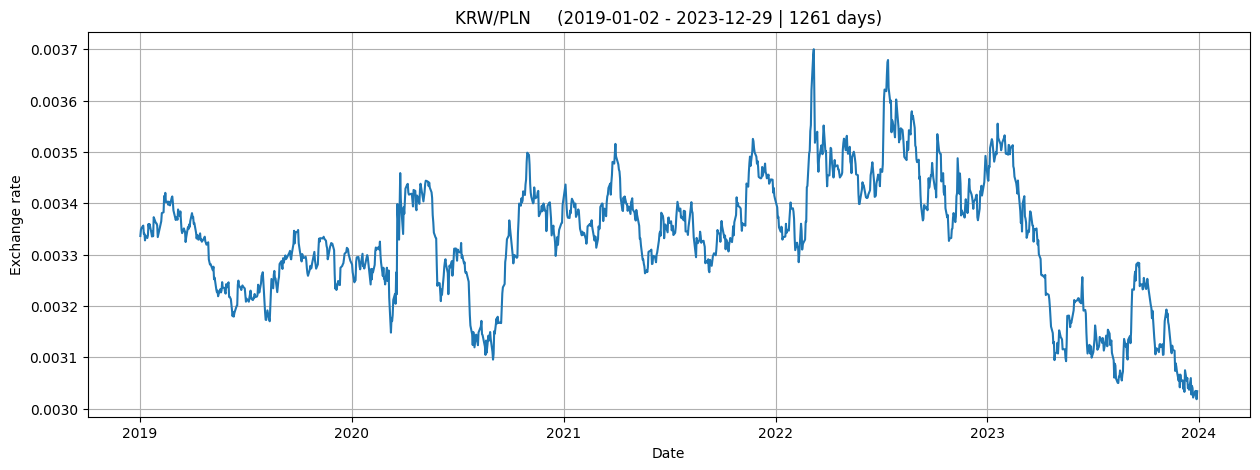

In [3]:
def plot_exchange_rate(data, title, filename=None):
    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['Value'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Exchange rate')
    plt.grid()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

date_format = '%Y-%m-%d'
first_date = data['Date'][0]
last_date = data['Date'][len(data)-1]
plot_title = f'{currency_name}     ({first_date.strftime(date_format)} - {last_date.strftime(date_format)} | {len(data)} days)'
plot_exchange_rate(data, plot_title, f'plots/{filename_prefix}_value.png')

Define `EMA`, `MACD` and `SIGNAL` functions

In [4]:
def EMA(data: pd.Series, start_index: int, n: int) -> float:
    alfa = 2 / (n + 1)
    nominator = 0.0
    denominator = 0.0
    counter = 0
    for i in range(start_index, start_index-n-1, -1):
        if i < 0:
            raise ValueError(f'N={n} is too large for index={start_index}')
        if np.isnan(data[i]):
            raise ValueError(f'Value at index {i} is NaN')

        nominator += data[i] * (1 - alfa)**counter
        denominator += (1 - alfa)**counter
        counter += 1

    return nominator / denominator

def MACD(data: pd.Series, index: int) -> float:
    return EMA(data, index, 12) - EMA(data, index, 26)

def SIGNAL(data: pd.Series, index: int) -> float:
    return EMA(data, index, 9)

Calculate MACD and SIGNAL values. Find the points where MACD crosses SIGNAL.

In [5]:
for record in data.iterrows():
    index = record[0]
    data.at[index, 'Action'] = 'HOLD'

    if index < 26:
        continue
    macd = MACD(data['Value'], index)
    data.at[index, 'MACD'] = macd
    
    if index < 35:
        continue
    signal = SIGNAL(data['MACD'], index)
    data.at[index, 'SIGNAL'] = signal

    data.at[index, 'Histogram'] = macd - signal
    
    # check if line crossed the signal line and stay above/below for at least (false_signals_offset) days
    prev_macd = data.at[index-false_signals_offset-1, 'MACD']
    prev_signal = data.at[index-false_signals_offset-1, 'SIGNAL']
    if np.isnan(prev_macd) or np.isnan(prev_signal):
        continue
    buy, sell = False, False

    if prev_macd < prev_signal and macd > signal:
        buy = True
    elif prev_macd > prev_signal and macd < signal:
        sell = True

    for i in range(index-false_signals_offset, index):
        if (data.at[i, 'MACD'] > data.at[i, 'SIGNAL']):
            sell = False
        elif (data.at[i, 'MACD'] < data.at[i, 'SIGNAL']):
            buy = False
    
    if buy and not sell:
        data.at[index, 'Action'] = 'BUY'
    elif sell and not buy:
        data.at[index, 'Action'] = 'SELL'


data[data['Action'] != 'HOLD']

,Date,Value,Action,MACD,SIGNAL,Histogram
55,2019-03-26,0.003350,BUY,-1.340096e-05,-0.000014,9.866515e-07
66,2019-04-10,0.003338,SELL,-2.186238e-06,-0.000002,-6.543148e-07
93,2019-05-22,0.003230,BUY,-2.651762e-05,-0.000028,1.372559e-06
105,2019-06-10,0.003180,SELL,-9.871184e-06,-0.000010,-1.312530e-07
111,2019-06-18,0.003201,BUY,-1.166414e-05,-0.000012,3.908516e-07
...,...,...,...,...,...,...
1169,2023-08-23,0.003072,BUY,-1.844419e-05,-0.000020,1.609773e-06
1190,2023-09-21,0.003239,SELL,4.787987e-05,0.000050,-1.644125e-06
1215,2023-10-26,0.003126,BUY,-3.554698e-05,-0.000036,2.202364e-07
1229,2023-11-15,0.003108,SELL,6.410568e-07,0.000001,-5.999790e-07


Show MACD and SIGNAL plot

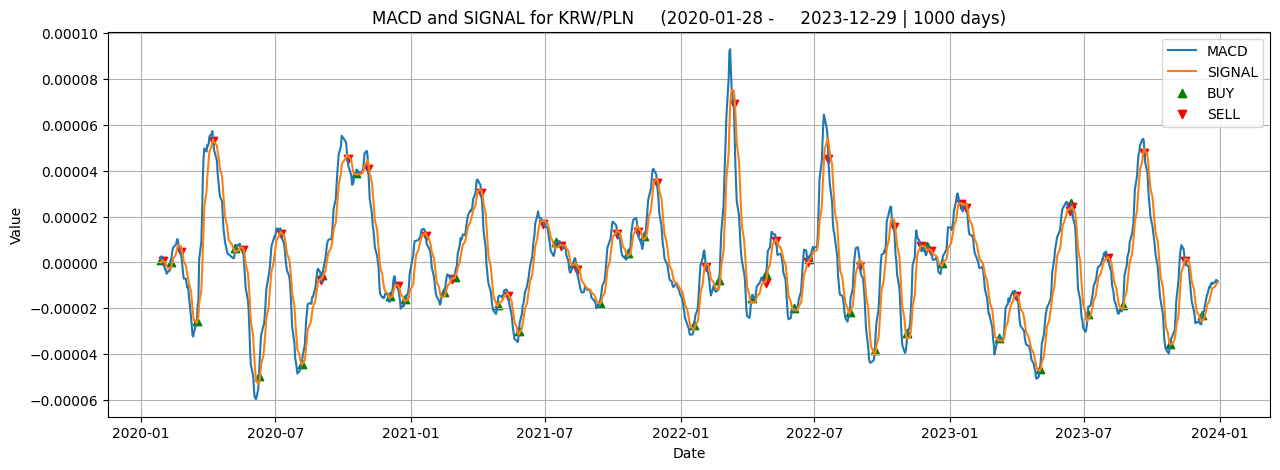

In [6]:
def plot_MACD_and_SIGNAL(data, title='MACD and SIGNAL', filename=None):
    buy_data = data[data['Action'] == 'BUY']
    sell_data = data[data['Action'] == 'SELL']

    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['MACD'])
    plt.plot(data['Date'], data['SIGNAL'])
    plt.scatter(buy_data['Date'], buy_data['MACD'], color='green', marker='^')
    plt.scatter(sell_data['Date'], sell_data['MACD'], color='red', marker='v')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid()
    plt.legend(['MACD', 'SIGNAL', 'BUY', 'SELL'])
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

tailed_data = data.tail(simulation_days_count).reset_index()
first_date = tailed_data['Date'][0]
last_date = tailed_data['Date'][len(tailed_data)-1]
date_format = '%Y-%m-%d'
plot_title = f'MACD and SIGNAL for {currency_name}     ({first_date.strftime(date_format)} - \
    {last_date.strftime(date_format)} | {len(tailed_data)} days)'
plot_MACD_and_SIGNAL(tailed_data, title=plot_title, filename=f'plots/{filename_prefix}_macd_signal.png')

Show exchange rate plot with buy and sell signals

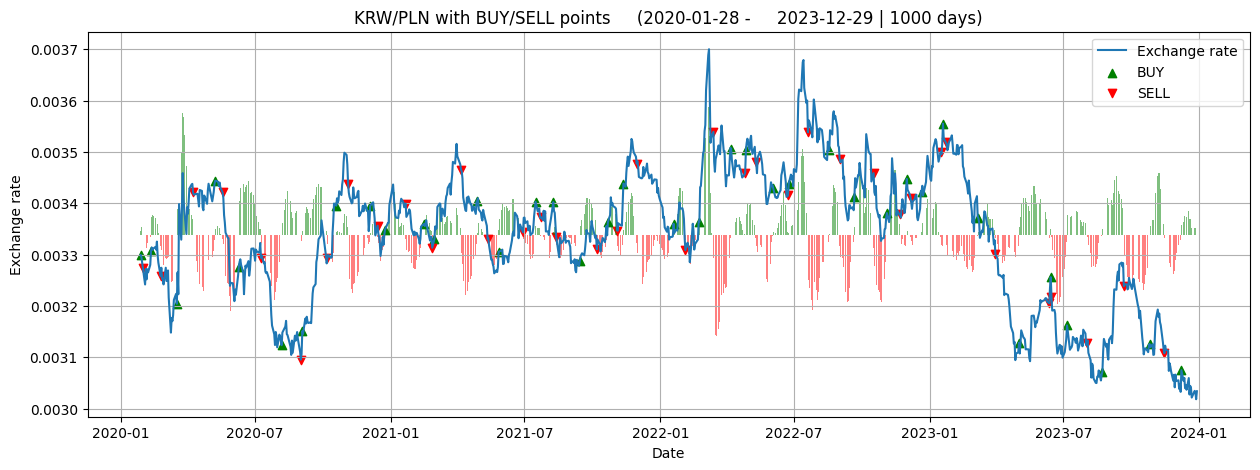

In [7]:
def plot_exchange_rate_with_buy_sell_points(data, title, filename=None, hist_scale=0.015):
    buy_data = data[data['Action'] == 'BUY']
    sell_data = data[data['Action'] == 'SELL']

    positive_histogram = data[data['Histogram'] > 0]
    negative_histogram = data[data['Histogram'] < 0]

    average = data['Value'].mean()
    hist_scale = average / data['Histogram'].abs().mean() * hist_scale

    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['Value'])
    plt.scatter(buy_data['Date'], buy_data['Value'], color='green', marker='^')
    plt.scatter(sell_data['Date'], sell_data['Value'], color='red', marker='v')

    plt.bar(positive_histogram['Date'], positive_histogram['Histogram'] * hist_scale, color='green', alpha=0.5, bottom=average)
    plt.bar(negative_histogram['Date'], negative_histogram['Histogram'] * hist_scale, color='red', alpha=0.5, bottom=average)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Exchange rate')
    plt.legend(['Exchange rate', 'BUY', 'SELL'])
    plt.grid()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

plot_data = data.tail(plot_days_count).reset_index()
first_date = plot_data['Date'][0]
last_date = plot_data['Date'][len(plot_data)-1]
plot_title = f'{currency_name} with BUY/SELL points     ({first_date.strftime(date_format)} - \
{last_date.strftime(date_format)} | {len(plot_data)} days)'
plot_exchange_rate_with_buy_sell_points(plot_data, title=plot_title, filename=f'plots/{filename_prefix}_value_buy_sell.png')

Simulate trading using MACD and SIGNAL.

In [8]:
initial_balance = 1_000
instrument_balance = initial_balance
alt_balance = 0

for record in tailed_data.iterrows():
    index = record[0]
    record_data = record[1]

    if record_data['Action'] == 'BUY':
        if alt_balance == 0:
            continue
        instrument_bought = alt_balance / record_data['Value']
        instrument_balance += instrument_bought
        alt_balance = 0
    elif record_data['Action'] == 'SELL':
        if instrument_balance == 0:
            continue
        alt_bought = instrument_balance * record_data['Value']
        alt_balance += alt_bought
        instrument_balance = 0

if alt_balance > 0:
    last_value = tailed_data.tail(1)['Value'].values[0]
    instrument_balance += alt_balance / last_value
    alt_balance = 0


output = f'''Simulation with {currency_name} ({len(tailed_data)} days), false signals offset: {false_signals_offset} days
Initial balance: {initial_balance:.2f}
Final balance: {instrument_balance:.2f}
Profit: {instrument_balance - initial_balance:.2f} ({(instrument_balance - initial_balance) / initial_balance * 100:.2f}%)
'''
print(output)
with open(f'results/{filename_prefix}_{false_signals_offset}_offset.txt', 'w') as file:
    file.write(output)

Simulation with KRW/PLN (1000 days), false signals offset: 0 days
Initial balance: 1000.00
Final balance: 1270.13
Profit: 270.13 (27.01%)

